In [1]:
###
# The goal of this notebook is to:
# - Look for categorization using traditional spike train measures

import glob
import os
from importlib import reload
import pickle
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import h5py as h5
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import pycuslsa as pyslsa

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20200127/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075', 'B1083-5']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
      'B1083-5': '/home/brad/krista/B1083/P03S05/'}


learned_stimuli = {'B1083': ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung'], 'B1056': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 'B1235': [], 'B1075': []}
peck_stimuli = {'B1083': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}, 'B1056': {'L': ['B_scaled_burung', 'D_scaled_burung'], 'R': ['A_scaled_burung', 'C_scaled_burung']}, 
                'B1235': {'L': ['F_scaled_burung', 'H_scaled_burung'], 'R': ['E_scaled_burung', 'G_scaled_burung'],}, 'B1075': {'L': ['F_40k', 'H_40k'], 'R': ['E_40k', 'G_40k']},
               'B1083-5': {'L': ['N_40k','P_40k'], 'R': ['M_40k', 'O_40k']}}

unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k']}
unfamiliar_stimuli = {'B1083': ['I_40k', 'J_40k', 'K_40k', 'L_40k'], 
                      'B1083-5': ['I_40k', 'J_40k', 'K_40k', 'L_40k'],
                      'B1235': ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung'], 
                      'B1075': ['A_40k', 'B_40k', 'C_40k', 'D_40k'], 
                      'B1056': ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
                     }

#bps =  {'B1056': '/home/AD/btheilma/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
#        'B1235': '/home/AD/btheilma/krista/B1235/P02S01/'}
#test_birds = ['B1075', 'B1083','B1056', 'B1235']
#test_birds = ['B1075', 'B1235']
#test_birds = ['B1056', 'B1235']
#test_birds =['B1056', 'B1083']
#test_birds = ['B1083-5']
test_birds = ['B1083']
# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.0*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'POP_SP_CORR_SPLIT'            # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

In [3]:
# Loop through each bird in our list and bin the data
for bird in test_birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-0.0_seg-0-0-POP_SP_CORR_SPLIT/20200115T163852Z-10.0-0.0.binned


In [13]:
# extract left vs right stims
# extract population tensors for the populations of interest
# Do not sort the stims

def poptens_to_smoothed_binmats(poptens, tau):
    ntrials = poptens.shape[2]
    out = []
    for trial in tqdm(range(ntrials)):
        mat = poptens[:, :, trial]
        out.append(gsmooth(mat, tau))
    return out

population_tensors_familiar_1 = {}
population_tensors_familiar_2 = {}
stimuli = []

for bird in test_birds:
    split_indices = np.random.permutation(poptens.shape[0])
    split_index = int(np.round(poptens.shape[0]/2.))
    poptens1_indices = split_indices[0:split_index]
    poptens2_indices = split_indices[split_index:100]
    stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
    print(stimuli)
    bdf = bdfs[bird]
    population_tensors_familiar_1[bird] = []
    population_tensors_familiar_2[bird] = []
    # open the binned data file
    with h5.File(bdf, 'r') as f:
        print(list(f.keys()))
        for stim in stimuli:
            poptens = np.array(f[stim]['pop_tens'])
            poptens1 = poptens[poptens1_indices, :, :]
            poptens2 = poptens[poptens2_indices, :, :]
            
            ncells, nwin, _ = poptens1.shape
            bin_tensor1 = threshold_poptens(poptens1, threshold)
            bin_tensor2 = threshold_poptens(poptens2, threshold)
            smoothed_tensors1 = poptens_to_smoothed_binmats(bin_tensor1, gaussian_tau)
            smoothed_tensors2 = poptens_to_smoothed_binmats(bin_tensor2, gaussian_tau)

            population_tensors_familiar_1[bird].append([smoothed_tensors1, stim])
            population_tensors_familiar_2[bird].append([smoothed_tensors2, stim])

['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [14]:
all_trials = sum([x[0] for x in population_tensors_familiar_1['B1083']], []) + sum([x[0] for x in population_tensors_familiar_2['B1083']], [])

# combined_poptens = population_tensors_familiar_1['B1083']
# combined_poptens.extend(population_tensors_familiar_2['B1083'])
# print(len(combined_poptens))


In [4]:
# flatten the list of population tensors for each population
threshold = 6
gaussian_tau = 1.0  # tau in number of bins (10ms)

def threshold_poptens(tens, thresh):
    ncell, nwins, ntrials = tens.shape
    frs = np.mean(tens, axis=1)
    tfr = thresh*frs
    tfrtens = np.tile(tfr[:, np.newaxis, :], (1, nwins, 1))
    bintens = 1*np.greater(tens, tfrtens)
    return bintens

def shuffle_binmat(binmat):
    ncells, nwin = binmat.shape
    for i in range(ncells):
        binmat[i, :] = np.random.permutation(binmat[i, :])
    return binmat

def filtered_response(spk_times, tau=1.):
    spk_times = spk_times.reshape((-1, 1))
    norm_factor = tau * np.sqrt(2. * np.pi)
    return lambda t: np.sum(np.exp(-(spk_times - t.reshape((1, -1))) ** 2 / (2 * tau * tau)), 0) / norm_factor

def gsmooth(mat, tau=1.):
    ncell, nwin = mat.shape
    retmat = np.zeros((ncell, nwin))
    sptms = [np.nonzero(t)[0] for t in mat]
    
    for c in range(ncell):
        fr = filtered_response(sptms[c], tau)
        frr = fr(np.arange(nwin))
        retmat[c, :] = frr
    return retmat

In [15]:
from numpy.linalg import norm

N = len(all_trials)
dmat = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x = all_trials[i]
        y = all_trials[j]
        mx = np.mean(x)
        my = np.mean(y)
        numerator = np.sum(np.multiply(x-mx, y-my))
        denom = np.sqrt(np.sum((x-mx)**2) * np.sum((y-my)**2))
        dmat[i, j] = numerator/denom
# with open(os.path.join(figsavepth, 'new2_Correl_{}_{}_{}_combined.pkl'.format('B1083', fa, o, gaussian_tau)), 'wb') as f:
#     pickle.dump(1-dmat, f)
# dmats[(pop_bird, o, fa)] = 1-dmat

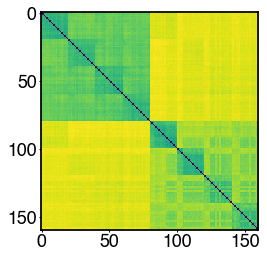

In [16]:
plt.imshow(1-dmat)

In [5]:
nreps = 40


def poptens_to_smoothed_binmats(poptens, tau):
    ntrials = poptens.shape[2]
    out = []
    for trial in tqdm(range(ntrials)):
        mat = poptens[:, :, trial]
        out.append(gsmooth(mat, tau))
    return out

dmats = {}
for rep in tqdm(range(nreps)):

    population_tensors_familiar_1 = {}
    population_tensors_familiar_2 = {}
    stimuli = []

    for bird in test_birds:
        split_indices = np.random.permutation(101)
        split_index = int(np.round(101/2.))
        poptens1_indices = split_indices[0:split_index]
        poptens2_indices = split_indices[split_index:100]
        stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
        print(stimuli)
        bdf = bdfs[bird]
        population_tensors_familiar_1[bird] = []
        population_tensors_familiar_2[bird] = []
        # open the binned data file
        with h5.File(bdf, 'r') as f:
            print(list(f.keys()))
            for stim in stimuli:
                poptens = np.array(f[stim]['pop_tens'])
                poptens1 = poptens[poptens1_indices, :, :]
                poptens2 = poptens[poptens2_indices, :, :]

                ncells, nwin, _ = poptens1.shape
                bin_tensor1 = threshold_poptens(poptens1, threshold)
                bin_tensor2 = threshold_poptens(poptens2, threshold)
                smoothed_tensors1 = poptens_to_smoothed_binmats(bin_tensor1, gaussian_tau)
                smoothed_tensors2 = poptens_to_smoothed_binmats(bin_tensor2, gaussian_tau)

                population_tensors_familiar_1[bird].append([smoothed_tensors1, stim])
                population_tensors_familiar_2[bird].append([smoothed_tensors2, stim])
    all_trials = sum([x[0] for x in population_tensors_familiar_1['B1083']], []) + sum([x[0] for x in population_tensors_familiar_2['B1083']], [])

    N = len(all_trials)
    dmat = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = all_trials[i]
            y = all_trials[j]
            mx = np.mean(x)
            my = np.mean(y)
            numerator = np.sum(np.multiply(x-mx, y-my))
            denom = np.sqrt(np.sum((x-mx)**2) * np.sum((y-my)**2))
            dmat[i, j] = numerator/denom
    with open(os.path.join(figsavepth, 'new2_Correl_{}_{}_{}_split_{}.pkl'.format('B1083', 'fam', 'orig', rep)), 'wb') as f:
        pickle.dump(1-dmat, f)
    dmats[rep] = 1-dmat


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [9]:
# shuffled

nreps = 40


def poptens_to_smoothed_shuffled_binmats(poptens, tau):
    ntrials = poptens.shape[2]
    out = []
    for trial in tqdm(range(ntrials)):
        mat = shuffle_binmat(poptens[:, :, trial])
        out.append(gsmooth(mat, tau))
    return out

dmats = {}
for rep in tqdm(range(nreps)):

    population_tensors_familiar_1 = {}
    population_tensors_familiar_2 = {}
    stimuli = []

    for bird in test_birds:
        split_indices = np.random.permutation(101)
        split_index = int(np.round(101/2.))
        poptens1_indices = split_indices[0:split_index]
        poptens2_indices = split_indices[split_index:100]
        stimuli = peck_stimuli[bird]['L'] + peck_stimuli[bird]['R']
        print(stimuli)
        bdf = bdfs[bird]
        population_tensors_familiar_1[bird] = []
        population_tensors_familiar_2[bird] = []
        # open the binned data file
        with h5.File(bdf, 'r') as f:
            print(list(f.keys()))
            for stim in stimuli:
                poptens = np.array(f[stim]['pop_tens'])
                poptens1 = poptens[poptens1_indices, :, :]
                poptens2 = poptens[poptens2_indices, :, :]

                ncells, nwin, _ = poptens1.shape
                bin_tensor1 = threshold_poptens(poptens1, threshold)
                bin_tensor2 = threshold_poptens(poptens2, threshold)
                smoothed_tensors1 = poptens_to_smoothed_shuffled_binmats(bin_tensor1, gaussian_tau)
                smoothed_tensors2 = poptens_to_smoothed_shuffled_binmats(bin_tensor2, gaussian_tau)

                population_tensors_familiar_1[bird].append([smoothed_tensors1, stim])
                population_tensors_familiar_2[bird].append([smoothed_tensors2, stim])
    all_trials = sum([x[0] for x in population_tensors_familiar_1['B1083']], []) + sum([x[0] for x in population_tensors_familiar_2['B1083']], [])

    N = len(all_trials)
    dmat = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = all_trials[i]
            y = all_trials[j]
            mx = np.mean(x)
            my = np.mean(y)
            numerator = np.sum(np.multiply(x-mx, y-my))
            denom = np.sqrt(np.sum((x-mx)**2) * np.sum((y-my)**2))
            dmat[i, j] = numerator/denom
    with open(os.path.join(figsavepth, 'new2_Correl_{}_{}_{}_split_{}.pkl'.format('B1083', 'fam', 'shuff', rep)), 'wb') as f:
        pickle.dump(1-dmat, f)
    dmats[rep] = 1-dmat


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


['N_40k', 'P_40k', 'M_40k', 'O_40k']
['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


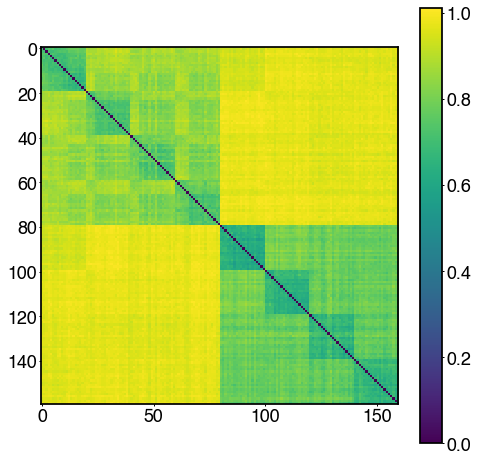

In [7]:
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
plt.figure(figsize=(8,8))
plt.imshow(dmats[1])
plt.colorbar()
#plt.title('B1083 Population 1 - Correlations')